In [1]:
import os
import sys
import pyts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

from tsx.perturbation import TimeSeriesPerturbation
from tsx.xai.lime import LIMETimeSeries
from tsx.xai import evaluation as eva

from data_util import *
from viz import *

import itertools
import pandas as pd
from biokit.viz import corrplot

### Objectives
1. Evaluate between different XAI models but same family (Ridge, for example)
1. Evaluate between different DL model, but same XAI model
1. Evaluate the same on Multivariate Time Series
1. (Todo) -> Evaluate the same on Univariate Time Series

### Metrics to Evaluation
1. coef correlations
1. r2-scores
    the scores when building XAI model in approximation process $f(z) ~ g(z') = w * z'$


## Prepare Data Set

In [3]:
independents = ["dew", "temp", "press", "wind_direction", "wind_speed", "snow", "rain"]
dependent = "pollution"

# Load data
df = load_data_set_bejin()
x_scaler, y_scaler = get_xy_scalers(df, independents, dependent)

# Normalize data 
df_norm = df.copy()
df_norm[independents] = x_scaler.transform(df[independents].values)
df_norm[dependent] = y_scaler.transform(df[dependent].values.reshape(-1, 1))

# Global param
n_steps = 128
window_size = 8
n_variables = len(independents)
samples_size = 100

In [4]:
# Prepare predict function
wavenet = tf.keras.models.load_model(f"{DATA_DIR}/wavenet_mts_128_1.h5")
lstm = tf.keras.models.load_model(f"{DATA_DIR}/lstm_mts_128_1.h5")

def predict_fn(z, model=lstm):
    z_reshaped = z.T.reshape(1, 128, 7)
    z_hat = model.predict(z_reshaped)
    # to avoid zero coef_ for z_hat in[0, 1]
    z_hat = y_scaler.inverse_transform(z_hat.reshape(-1, 1))  
    z_hat = z_hat.ravel()   # z_hat will arround 50 - 150
    return z_hat[0]

def lstm_fn(z):
    return predict_fn(z, model=lstm)

def wavenet_fn(z):
    return predict_fn(z, model=wavenet)

In [5]:
# Prepare multi-run instances
instances = []
n_instances = 3
for i in range(n_instances):
    _x_df = get_instance_x(df_norm, n_steps, independents)
    instances.append(_x_df.values.T)

In [6]:
# Prepare Params for different models
scales = ["async", "sync"]
repl_fn = ["zeros", "local_mean", "global_mean"]
model_fn = ["lstm_fn", "wavenet_fn"]

params = list(itertools.product(scales, repl_fn, model_fn))
params_df = pd.DataFrame([{"scale": s, "method": m, "model":model} for s, m, model in params])
# print(params_df)
params_df.style\
    .apply(lambda s: ['background-color: %s' % ('grey' if v else '') for v in s == "async"]) \
    .apply(lambda s: ['background-color: %s' % ('green' if v else '') for v in s == "sync"]) \
    .applymap(lambda s: 'color: %s' % ('cyan' if s == "lstm_fn" else '' )) \
    .applymap(lambda s: 'color: %s' % ('orange' if s == "wavenet_fn" else '' ))

,scale,method,model
0,async,zeros,lstm_fn
1,async,zeros,wavenet_fn
2,async,local_mean,lstm_fn
3,async,local_mean,wavenet_fn
4,async,global_mean,lstm_fn
5,async,global_mean,wavenet_fn
6,sync,zeros,lstm_fn
7,sync,zeros,wavenet_fn
8,sync,local_mean,lstm_fn
9,sync,local_mean,wavenet_fn


In [7]:
print(params_df.to_latex())

\begin{tabular}{llll}
\toprule
{} &  scale &       method &       model \\
\midrule
0  &  async &        zeros &     lstm\_fn \\
1  &  async &        zeros &  wavenet\_fn \\
2  &  async &   local\_mean &     lstm\_fn \\
3  &  async &   local\_mean &  wavenet\_fn \\
4  &  async &  global\_mean &     lstm\_fn \\
5  &  async &  global\_mean &  wavenet\_fn \\
6  &   sync &        zeros &     lstm\_fn \\
7  &   sync &        zeros &  wavenet\_fn \\
8  &   sync &   local\_mean &     lstm\_fn \\
9  &   sync &   local\_mean &  wavenet\_fn \\
10 &   sync &  global\_mean &     lstm\_fn \\
11 &   sync &  global\_mean &  wavenet\_fn \\
\bottomrule
\end{tabular}



In [8]:
# Run multin-run explains for different xai models (# dl model)

# Todo: add this function to lime.py
#   coef_to_original = m.perturb_obj._x_masked
x_df = get_instance_x(df_norm, n_steps, independents)
x_arr = x_df.values.T

# Prepare for multi-processing pool
def _process(scale, method, model):
    # scale, method, model = p
    lime_ts = LIMETimeSeries(
        scale=scale, 
        window_size=window_size,                                
        sample_size=samples_size, 
        perturb_method=method
    )
    lime_ts.explain_instances(instances, predict_fn=eval(model))
    coef = lime_ts.coef 
    x_coef = lime_ts.perturb_obj._x_masked(x_arr, coef)
    r2_score = lime_ts.score
    name = f"{scale}-{method}-{model}"
    d = {
        "name": name,
        "scale": scale,
        "perturb_method": method,
        "model":model,
        "coef": coef,
        "x_coef": x_coef,
        "r2": r2_score
    }
    return name, d

In [9]:
# Test with no
xai_models = {}
for scale, method, model in params:
    name, _ = _process(scale, method, model)
    xai_models[name] = _

In [10]:
# d {name: {name:..., scale:..., r2:..., coef:...}}
def get_models(d, scale=None, perturb_method=None, model=None):
    if scale:
        d = {name:m for name, m in d.items() if m["scale"] == scale}
    if perturb_method:
        d = {name:m for name, m in d.items() if m["perturb_method"] == perturb_method}
    if model:
        d = {name:m for name, m in d.items() if m["model"] == model}
    return d

def get_coefs(d):
    coefs = [(name, m["coef"].ravel()) for name, m in d.items()]
    return zip(*coefs)

def get_r2(d):
    r2 = [(name, m["r2"]) for name, m in d.items()] 
    return zip(*r2)

def get_xcoefs(d):
    xcoefs = [(name, m["x_coef"].ravel()) for name, m in d.items()]
    return zip(*xcoefs)

In [11]:
# Vis Functions
import seaborn as sns

def plt_corr_coef(d, **sns_kwargs):
    names, xcoefs = get_xcoefs(d)
    coefs_corr = eva.corr_matrix(list(xcoefs), names)

    # kwargs = dict(method='square', shrink=.9, rotation=45, colorbar=False)
    # corrplot.Corrplot(coefs_corr).plot(**kwargs)

    sns_kwargs["cmap"] = sns_kwargs.get("cmap") or "Reds"

    mask = np.ones_like(coefs_corr)
    mask[np.triu_indices_from(mask)] = False
    sns.heatmap(coefs_corr.round(2), mask=mask.T, **sns_kwargs)

def plt_r2_score(d, **sns_kwargs):
    names, r2_scores = get_r2(d)
    r2_scores_df = pd.DataFrame({
        "names":names, 
        "r2_scores":r2_scores,
        "scale": [m["scale"] for name, m in d.items()],
        "method": [m["perturb_method"] for name, m in d.items()],
        "model": [m["model"] for name, m in d.items()],
        })

    # df1["names"].str.extract(r'(?P<scale>\w*)-(?P<method>\w*)-(?P<model>\w*)')

    sns_kwargs["hue"] = sns_kwargs.get("hue") or "scale"
    bar_plt = sns.barplot(y="names", x="r2_scores", data=r2_scores_df, **sns_kwargs)

def plt_adjust_ticklabel_color(ax, axis="xaxis", c=["blue", "orange"], word="async"):
    if axis == "xaxis":
        tick_labels = ax.get_xticklabels()
    else:
        tick_labels = ax.get_yticklabels()
    for i in tick_labels:
        if word in i.get_text():
            i.set_color(c[0]) 
        else:
            i.set_color(c[1])

Text(0.5, 1.0, 'Feature Importance Correlation for MTS Perturbation Method \n (model: lstm, window_size=8)')

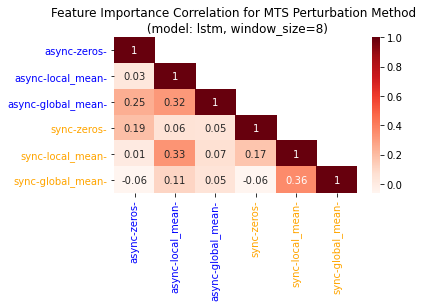

In [12]:
# Evaluation 1 - Within XAI family model, between perturbation-methods, same DL model
# Eva 1a - Important Features Correlation (MTS)
d = get_models(xai_models, model='lstm_fn')
plt_corr_coef(d, annot=True)

ax = plt.gca()

ylabels = [i.get_text() for i in ax.get_yticklabels()]
ylabels = [l.replace("lstm_fn", "") for l in ylabels]
ax.set_yticklabels(ylabels)
ax.set_xticklabels(ylabels)

plt_adjust_ticklabel_color(ax, "xaxis", word="async")
plt_adjust_ticklabel_color(ax, "yaxis", word="async")

plt.tight_layout()
plt.title("Feature Importance Correlation for MTS Perturbation Method \n (model: lstm, window_size=8)")

Text(0.5, 1.0, 'R2 Score for different perturbation methods \n (model: lstm, window_size=8)')

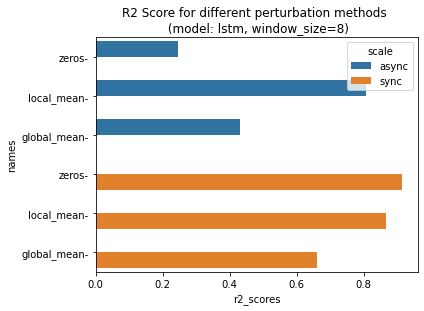

In [13]:
# Eva 1b - R2 Score in Approximation of Perturbation Methods (MTS)
d = get_models(xai_models, model='lstm_fn')
plt_r2_score(d)
# plt.xticks(rotation=70)
ax = plt.gca()

ylabels = [i.get_text() for i in ax.get_yticklabels()]
ylabels = [l.replace("async-", "") for l in ylabels]
ylabels = [l.replace("sync-", "") for l in ylabels]
ylabels = [l.replace("lstm_fn", "") for l in ylabels]
ax.set_yticklabels(ylabels)

plt.tight_layout()
plt.title("R2 Score for different perturbation methods \n (model: lstm, window_size=8)")
# Todo: rename yticks, rename xticks

Text(0.5, 1.0, 'Feature Importance Correlation for deep learning models \n (method: local_mean, window_size=8)')

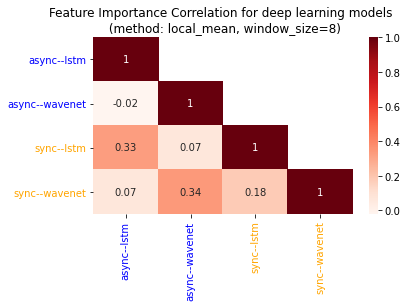

In [14]:
# Evaluation 2 - different DL models, same XAI models
# Eva 2a - Coef correlation
d = get_models(xai_models, perturb_method='local_mean')
plt_corr_coef(d, annot=True)

ax = plt.gca()

ylabels = [i.get_text() for i in ax.get_yticklabels()]
ylabels = [l.replace("local_mean", "") for l in ylabels]
ylabels = [l.replace("_fn", "") for l in ylabels]
ax.set_yticklabels(ylabels)
ax.set_xticklabels(ylabels)

plt_adjust_ticklabel_color(ax, "xaxis", word="async")
plt_adjust_ticklabel_color(ax, "yaxis", word="async")

plt.tight_layout()
plt.title("Feature Importance Correlation for deep learning models \n (method: local_mean, window_size=8)")


Text(0.5, 1.0, 'R2 Score for simulating deep learning models \n (method: local_mean, window_size=8)')

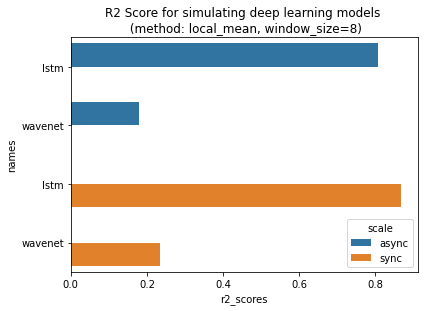

In [15]:
# Eva 2b - R2 Score
plt_r2_score(d, hue="scale")
ax = plt.gca()

ylabels = [i.get_text() for i in ax.get_yticklabels()]
ylabels = [l.replace("async-", "") for l in ylabels]
ylabels = [l.replace("sync-", "") for l in ylabels]
ylabels = [l.replace("local_mean-", "") for l in ylabels]
ylabels = [l.replace("_fn", "") for l in ylabels]
ax.set_yticklabels(ylabels)

plt.tight_layout()
plt.title("R2 Score for simulating deep learning models \n (method: local_mean, window_size=8)")
# Todo: rename yticks, rename xticks

In [16]:
# Evalutaion 3a: Table of Scale-Model/perturbation-method for R2 score.
#   Row:    Scale-Model (eg: Async-lstm)
#   Col:    Perturbation method (eg. Local Mean, Zeros, .etc)
#   Cell:   R2 scores

d = get_models(xai_models)
_, m = zip(*d.items())
models_df = pd.DataFrame(m)
models_df["name"] = models_df["scale"] + "-" + models_df["model"].str.replace("_fn", "")
r2_df = models_df.drop(["coef", "x_coef", "scale", "model"], axis=1)
r2_df = r2_df.rename({"name": "scale-model"}, axis=1)
r2_df_pivot = r2_df.pivot(index='scale-model', columns='perturb_method', values='r2')
r2_df_pivot = r2_df_pivot.round(2)

In [17]:
r2_df_pivot.style\
    .highlight_max(color='green')\
    .highlight_min(color='purple')\
    .format(lambda x: "{:.2f}".format(x))
    # .background_gradient(cmap='viridis', low=.5, high=0)


perturb_method,global_mean,local_mean,zeros
scale-model,,,
async-lstm,0.43,0.81,0.25
async-wavenet,0.07,0.18,-0.18
sync-lstm,0.66,0.87,0.91
sync-wavenet,0.42,0.23,0.51


In [18]:
print(r2_df_pivot.to_latex())

\begin{tabular}{lrrr}
\toprule
perturb\_method &  global\_mean &  local\_mean &  zeros \\
scale-model   &              &             &        \\
\midrule
async-lstm    &         0.43 &        0.81 &   0.25 \\
async-wavenet &         0.07 &        0.18 &  -0.18 \\
sync-lstm     &         0.66 &        0.87 &   0.91 \\
sync-wavenet  &         0.42 &        0.23 &   0.51 \\
\bottomrule
\end{tabular}



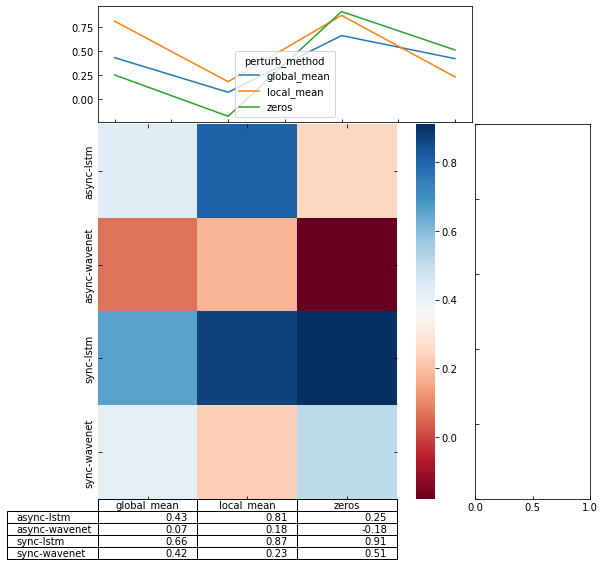

In [19]:
# Evalutaion 3a:
#   Center: Table of r2_df
#   Above table: Plot async-local-mean xcoef
#   Right table: Plot sync-local-mean xcoef

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_above = [left, bottom + (height + spacing) * 1, width, 0.2]
rect_center = [left, bottom, width, height]
rect_right = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(8, 8))

ax_above = plt.axes(rect_above)
ax_center = plt.axes(rect_center)
ax_right = plt.axes(rect_right)

ax_center.tick_params(direction='in', top=True, right=True, labelbottom=False)
ax_above.tick_params(direction='in', labelbottom=False)
ax_right.tick_params(direction='in', labelleft=False)


sns.heatmap(
    r2_df_pivot, 
    ax=ax_center, 
    cmap="RdBu",
    # annot=True, 
    )
ax_center.set_ylabel('')    
ax_center.set_xlabel('')
labels = [i.get_text() for i in ax_center.get_yticklabels()]
ax_center.set_yticklabels(labels, va="center")
pd.plotting.table(ax_center, r2_df_pivot)

r2_df_pivot.plot(ax=ax_above)
# now determine nice limits by hand:
# binwidth = 0.25
# lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
# ax_center.set_xlim((-lim, lim))
# ax_center.set_ylim((-lim, lim))

# bins = np.arange(-lim, lim + binwidth, binwidth)
# ax_histx.hist(x, bins=bins)
# ax_histy.hist(y, bins=bins, orientation='horizontal')

# ax_histx.set_xlim(ax_scatter.get_xlim())
# ax_histy.set_ylim(ax_scatter.get_ylim())


<AxesSubplot:xlabel='scale-model'>

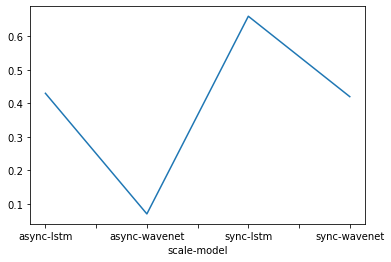

In [20]:
r2_df_pivot.iloc[:,0].plot()

In [21]:
print(r2_df_pivot.to_latex())

\begin{tabular}{lrrr}
\toprule
perturb\_method &  global\_mean &  local\_mean &  zeros \\
scale-model   &              &             &        \\
\midrule
async-lstm    &         0.43 &        0.81 &   0.25 \\
async-wavenet &         0.07 &        0.18 &  -0.18 \\
sync-lstm     &         0.66 &        0.87 &   0.91 \\
sync-wavenet  &         0.42 &        0.23 &   0.51 \\
\bottomrule
\end{tabular}

